#### 0. Loading requirements

In [1]:
import dataframe_image as dfi
import datasets
import interpret.glassbox
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy as sp
from scraper import *
import seaborn as sns
import shap
import sklearn
from sklearn.preprocessing import OneHotEncoder
import xgboost

#### 1. Summary Statistics and Visualizations

Getting summary statistics for metric and categorical variables.

In [2]:
# Importing csv file with the data
data = pd.read_csv("Product_Table_complete.csv")

In [3]:
# Get dimension of the dataset
print(data.shape)

(1687, 48)


In [4]:
# Generating a dataframe with all metric variables
metric_variables = get_metric_variables(data)
# Generating a dataframe with all categorical variables
categorical_variables = get_categorical_variables(data)
# Calculating summary statistics for all metric variables
metric_variables_summary = get_metric_variables_summary(metric_variables)
# Save them as a png
saving_table_as_png(metric_variables_summary, 'metric_variables_table.png')
# Generating a dictionary with summary statistics for every categorical feature
categorical_variables_summary = get_categorical_variables_summary(categorical_variables)
# Save summary for features "online-retailer", "brand" and "processor manufacturer" as png
saving_table_as_png(categorical_variables_summary['online-retailer'], 'online-retailer_table.png')
saving_table_as_png(categorical_variables_summary['brand'][0:5], 'brand_table.png')
saving_table_as_png(categorical_variables_summary['processor manufacturer'][0:5], 'processor_table.png')
# Correlation matrix for metric variables
correlation_matrix = metric_variables.corr()

Create one chart with statistics comparing the three retailers. Getting average price of products, number of products. Brand with number of products that is sold the most.

In [5]:
# Group by online-retailer and calculate average price and most supplied brands and colours
retailer_table = get_online_retailer_comparison_table(data)
# Saving the table as png
saving_table_as_png(retailer_table, 'online_retailer_comp.png')

Creating some visualizations to analyze some variables.

Bar Plots

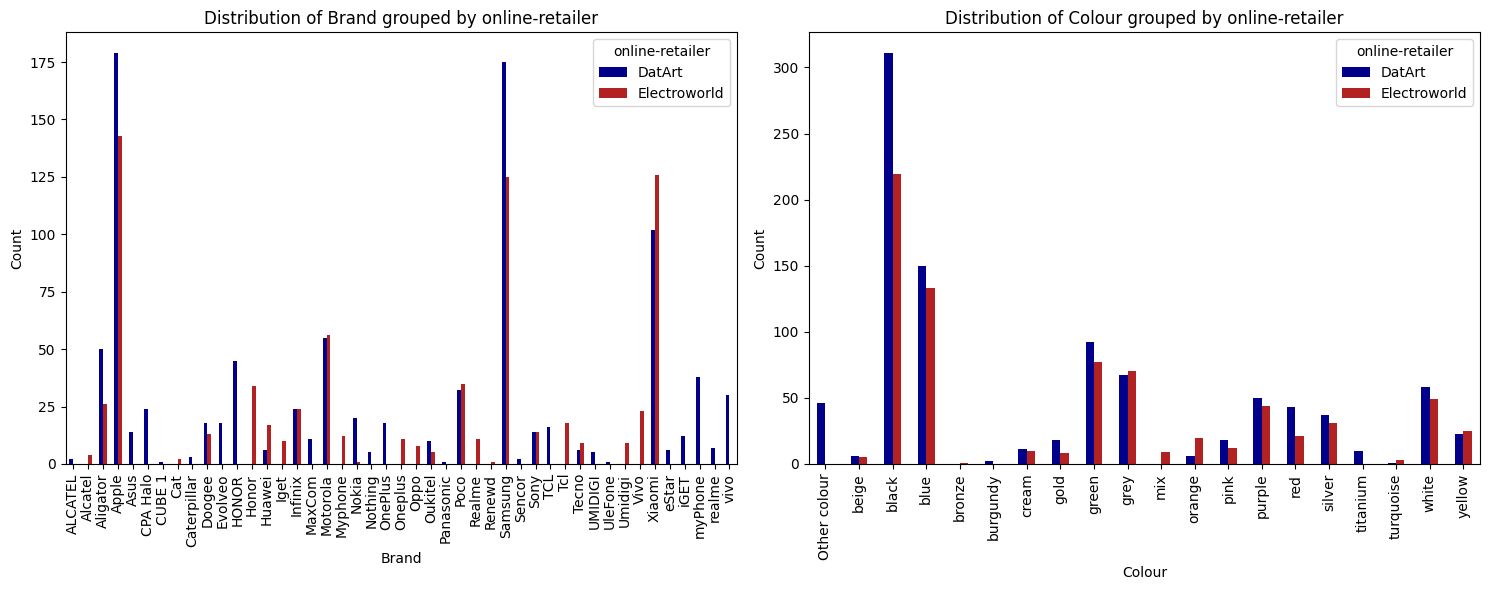

In [6]:
# List of variables to plot
variables_to_plot = ['brand', 'colour']
grouping_variable = 'online-retailer'  # Secondary variable for grouping

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for specific retailers
colors = {'Electroworld': 'firebrick', 'DatArt': 'darkblue'}

# Plot grouped bar chart for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]  # Get the current axis
    grouped_data = data.groupby([variable, grouping_variable]).size().unstack()

    # Plot the grouped bar charts
    grouped_data.plot(kind='bar', ax=ax, color=[colors.get(c, 'grey') for c in grouped_data.columns])
    ax.set_title(f'Distribution of {variable.capitalize()} grouped by {grouping_variable}')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
# Saving plot in current wd in the "images" directory 
saving_plot("bar_plots_grouped.png")

Pie Plots

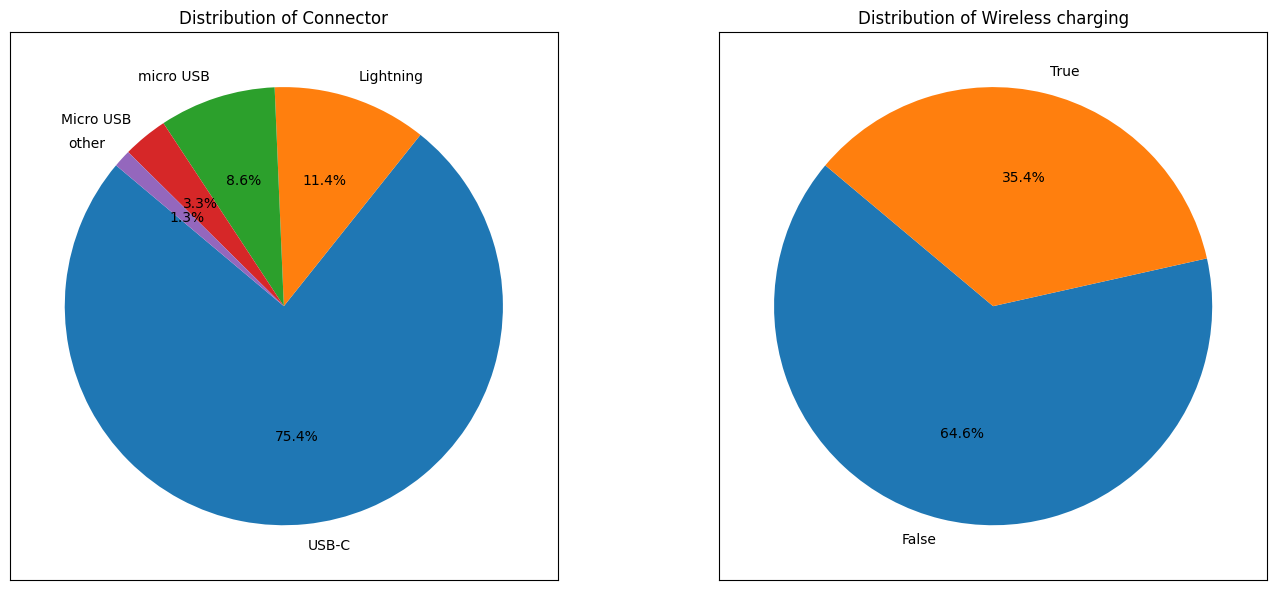

In [8]:
# List of variables to plot
variables_to_plot = ['connector', 'wireless charging']

# Set seaborn style and color palette
color_palette = sns.color_palette("tab10")

# Create a 1x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot pie chart with percentages for each variable
for idx, variable in enumerate(variables_to_plot[:2]):  # Plot only the first two variables
    ax = axes[idx]  # Get the current axis
    category_counts = data[variable].value_counts()
    category_percentages = (category_counts / category_counts.sum()) * 100
    pie = category_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140, ax=ax, colors=color_palette)
    ax.set_title(f'Distribution of {variable.capitalize()}')
    ax.set_ylabel('')

    # Add frame
    ax.set_frame_on(True)

# Adjust layout
plt.tight_layout()

saving_plot("pie_plots.png")

Scatterplots

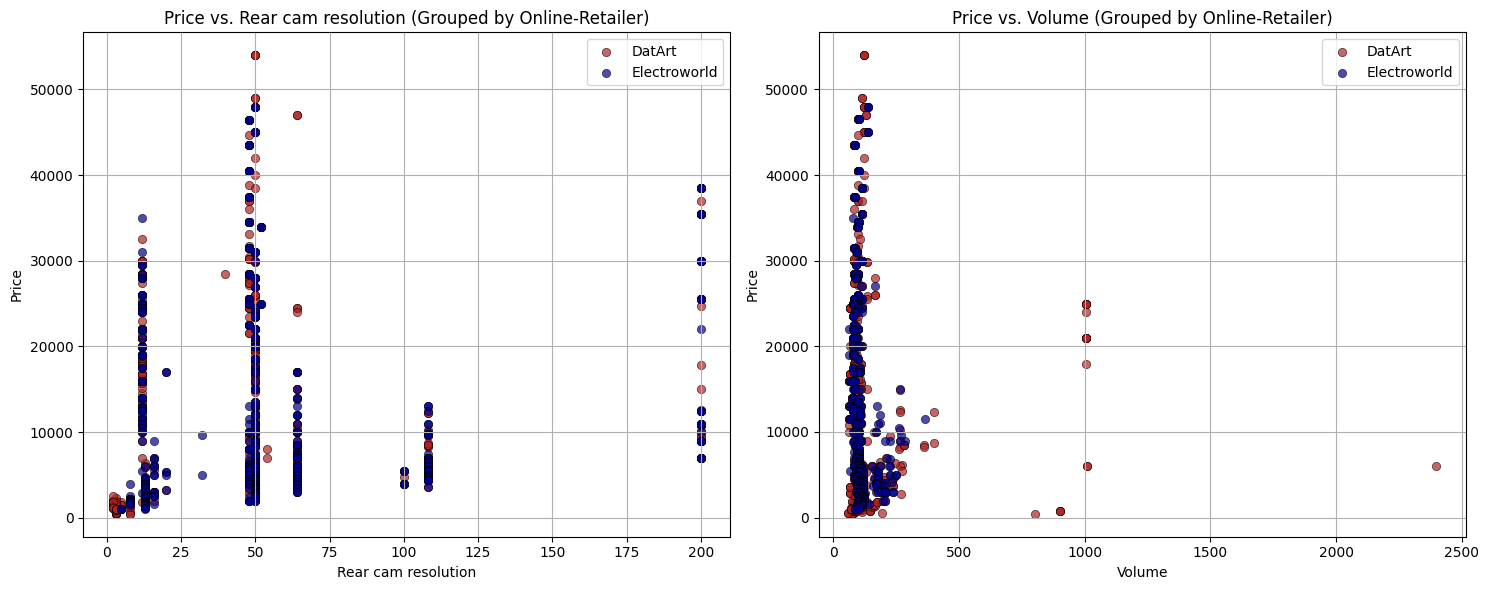

In [9]:
# List of variables to plot
variables_to_plot = ['rear cam resolution', 'volume']
online_retailer = ['DatArt', 'Electroworld']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each online retailer
retailer_colors = {'DatArt': 'firebrick', 'Electroworld': 'darkblue'}

# Plot scatter plot for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]# Get the current axis
    
    # Plot scatter plot for each online retailer
    for retailer in online_retailer:
        subset_data = data[data['online-retailer'] == retailer]
        ax.scatter(subset_data[variable], subset_data['price'], c=retailer_colors[retailer], label=retailer, alpha=0.7, edgecolors='black', linewidth=0.5)
        
    ax.set_title(f'Price vs. {variable.capitalize()} (Grouped by Online-Retailer)')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()

saving_plot("scatter_plots_retailer.png")

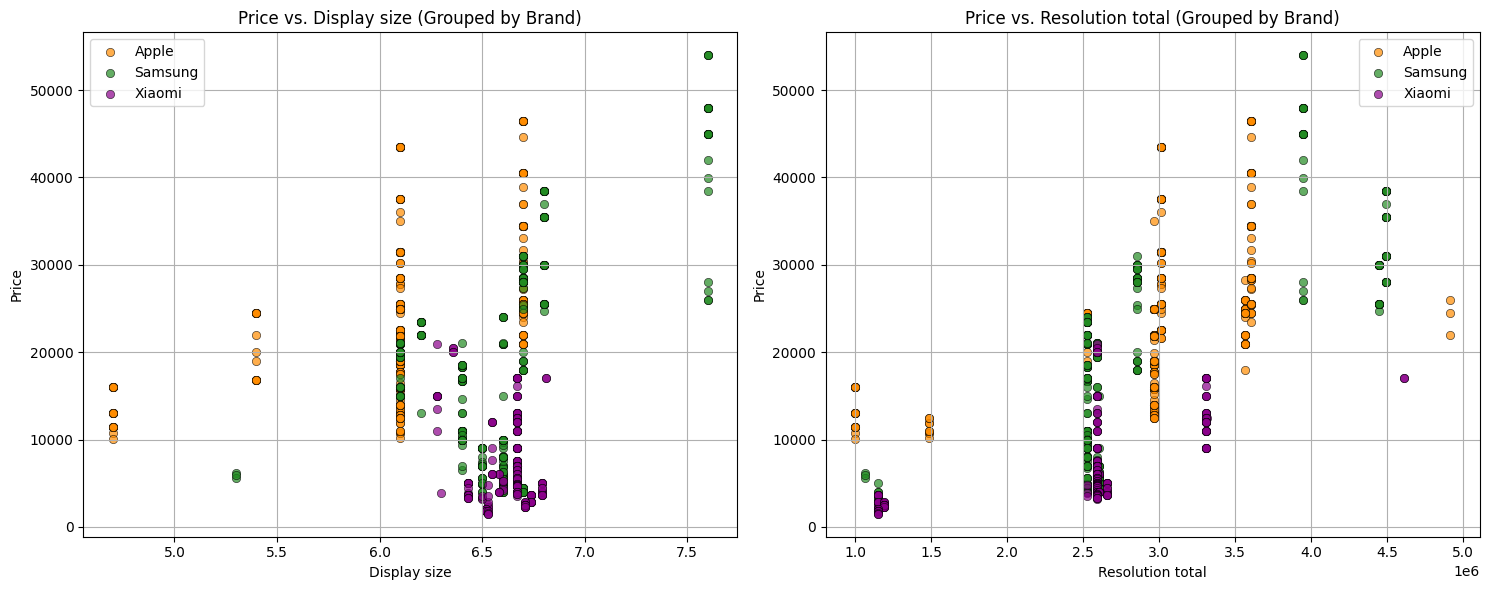

In [10]:
# List of variables to plot
variables_to_plot = ['display size', 'resolution total']
brands = ['Apple', 'Samsung', 'Xiaomi']

# Create a 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each online retailer
brands_colors = {'Apple': 'darkorange', 'Samsung': 'forestgreen', 'Xiaomi': 'darkmagenta'}

# Plot scatter plot for each variable
for idx, variable in enumerate(variables_to_plot):
    ax = axes[idx]  # Get the current axis
    
    # Plot scatter plot for each online retailer
    for brand in brands:
        subset_data = data[data['brand'] == brand]
        ax.scatter(subset_data[variable], subset_data['price'], c=brands_colors[brand], label=brand, alpha=0.7, edgecolors='black', linewidth=0.5)
        
    ax.set_title(f'Price vs. {variable.capitalize()} (Grouped by Brand)')
    ax.set_xlabel(variable.capitalize())
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()

saving_plot("scatter_plots_brand.png")

Histograms/Density Plots

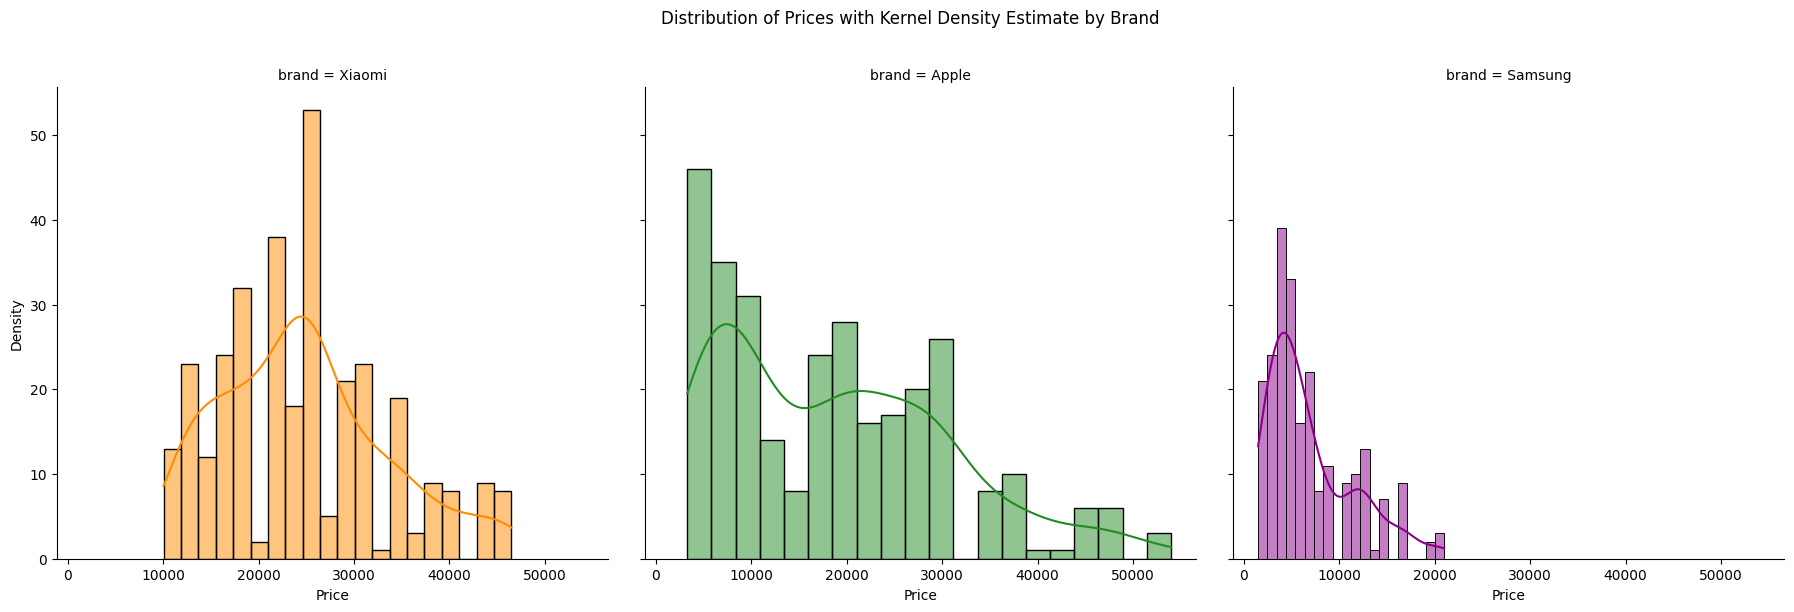

In [11]:
# Set up the FacetGrid
subset_data = data[data['brand'].isin(['Apple', 'Samsung', 'Xiaomi'])]

# Define custom colors for the brands
custom_palette = {'Apple': 'darkorange', 'Samsung': 'forestgreen', 'Xiaomi': 'darkmagenta'}

# Create the FacetGrid with custom palette
g = sns.FacetGrid(subset_data, col='brand', height=6)

# Plot histogram with KDE for each retailer
for brand, ax in zip(['Apple', 'Samsung', 'Xiaomi'], g.axes.flat):
    sns.histplot(subset_data[subset_data['brand'] == brand]['price'], 
                 bins=20, kde=True, edgecolor='black', color=custom_palette[brand], ax=ax)

# Add labels and title
g.set_axis_labels('Price', 'Density')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Prices with Kernel Density Estimate by Brand')

saving_plot("histogram_grouped_brand.png")

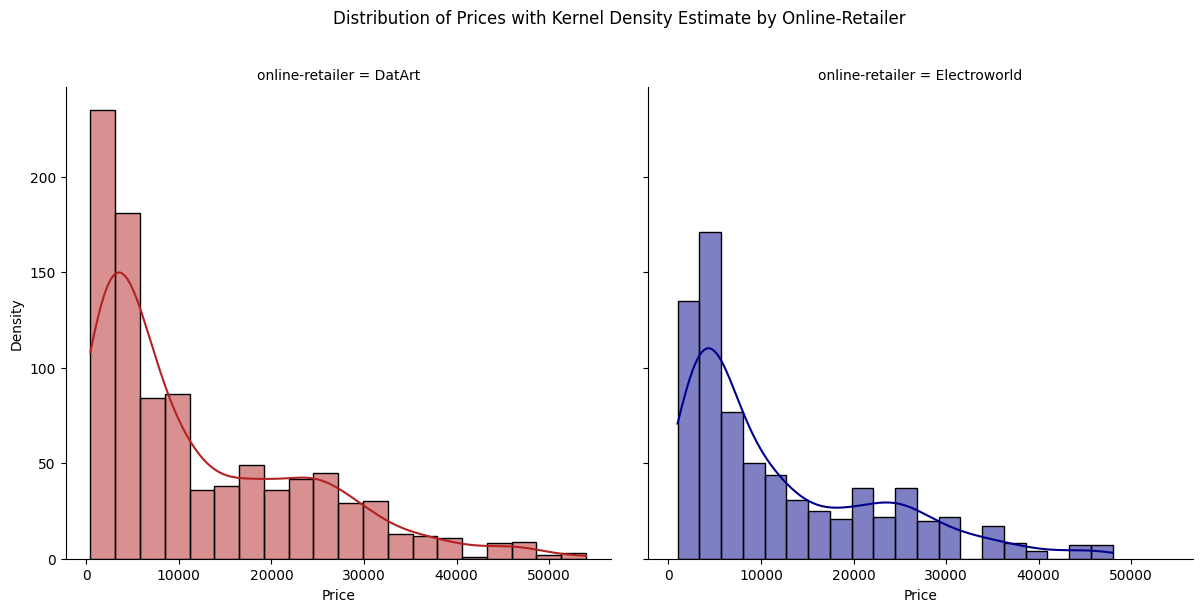

In [12]:
# Set up the FacetGrid
subset_data = data[data['online-retailer'].isin(['DatArt', 'Electroworld'])]

# Define custom colors for the brands
custom_palette = {'DatArt': 'firebrick', 'Electroworld': 'darkblue'}

# Create the FacetGrid with custom palette
g = sns.FacetGrid(subset_data, col='online-retailer', height=6)

# Plot histogram with KDE for each retailer
for online_retailer, ax in zip(['DatArt', 'Electroworld'], g.axes.flat):
    sns.histplot(subset_data[subset_data['online-retailer'] == online_retailer]['price'], 
                 bins=20, kde=True, edgecolor='black', color=custom_palette[online_retailer], ax=ax)

# Add labels and title
g.set_axis_labels('Price', 'Density')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Distribution of Prices with Kernel Density Estimate by Online-Retailer')

saving_plot("histogram_grouped_retailer.png")

Heatmap

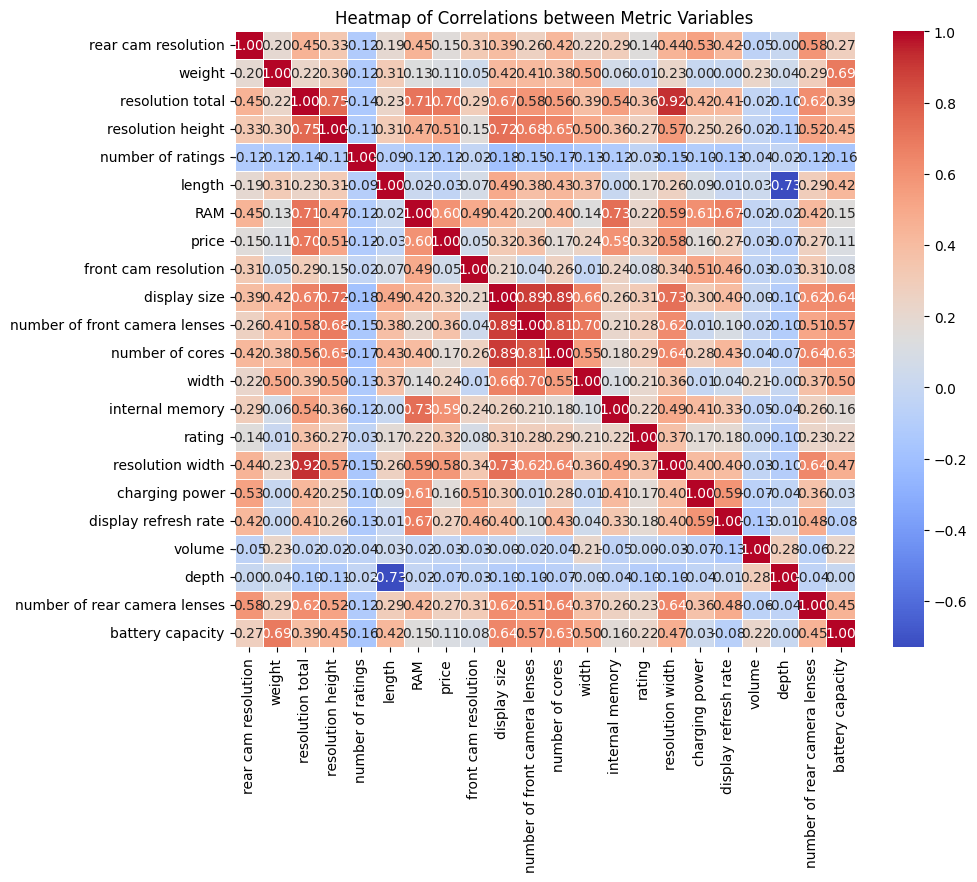

In [13]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Correlations between Metric Variables')

saving_plot("heatmap_corr.png")

#### 2. Pre-processing variables for price model application

In [14]:
# Data is prepared for modelling. Categorical variables are One-hot encoded, boolean variables converted to 0/1 variables and NA's removed.
float_variables_to_exclude = ['rating', 'resolution width', 'resolution height']
integer_variables_to_exclude = ['ID', 'number of ratings']
categorical_variables_to_exclude = ['configuration cards', 'title', 'processor model']

model_data = generate_model_dataset(data, integer_variables_to_exclude, float_variables_to_exclude, categorical_variables_to_exclude)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Additive Nature of SHAP values: "For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained".

#### 3. Price Modelling

Generalized Additive Regression Model (GAM's) - InterpretMLs explainable boosting machines

In [15]:
# Defining modelling variables
y = model_data['price']
# Log-transform the target variable y
y_log = pd.Series(np.log(y), name='log_price')
X = model_data.drop(columns = ['price'])

# Sampling 100 obs for use as the background distribution
X100 = shap.utils.sample(X, 100) 

# Fitting GAM
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y_log)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

PermutationExplainer explainer: 1122it [01:58,  8.99it/s]                          


Partial dependence plot: Calculation of SHAP Value, as difference between partial dependence plot (at the feature's values) and expected model output (average of predicted prices). 

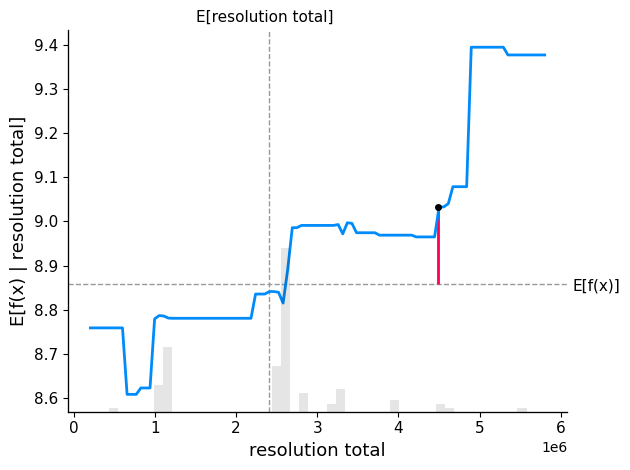

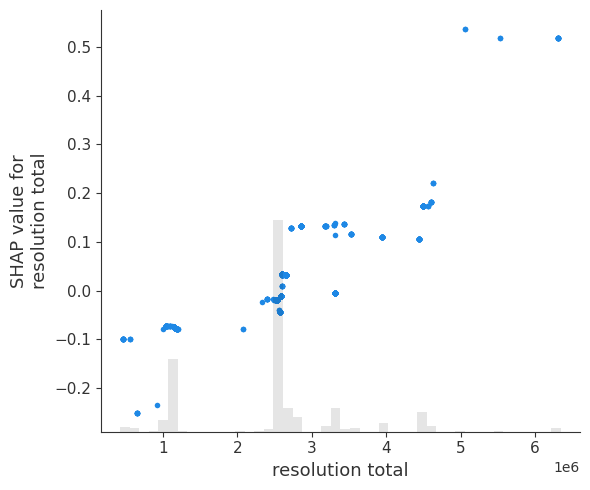

In [16]:
# make a standard partial dependence plot with a single SHAP value overlaid
sample_ind = 40
fig, ax = shap.partial_dependence_plot(
    "resolution total",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)
# Adjusting layout
plt.tight_layout()
saving_plot("GAM_partial_dep_plot.png")

# Create SHAP value scatter plot
shap.plots.scatter(shap_values_ebm[:, "resolution total"],show=False)
# Adjusting layout
plt.tight_layout()
# Save the plot as a PNG file
saving_plot("GAM_shap_scatter_plot_resolution_total.png")

In [36]:
# Plot waterfall plot for Shapley values for one data point
shap.plots.waterfall(shap_values_ebm[40], max_display=20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_plot.png")

In [42]:
# Plot waterfall plot for Shapley values distribution
shap.plots.beeswarm(shap_values_ebm, max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_distr_plot.png")

In [43]:
# Plot beeswarm plot for distribution of absolute Shapley values
shap.plots.beeswarm(shap_values_ebm.abs, color="shap_red", max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_abs_plot.png")

In [44]:
# Plot waterfall plot for mean absolute Shapley values 
shap.plots.bar(shap_values_ebm, max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot("GAM_shap_waterfall_mean_plot.png")

Non-additive boosted tree-model

In [45]:
# Fit non-additive boosted tree model
model_xgb = xgboost.XGBRegressor(n_estimators=10000, max_depth=2).fit(X, y_log)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100) 
shap_values_xgb = explainer_xgb(X)

 99%|===================| 1114/1121 [02:05<00:00]        

In [46]:
sample_ind = 40
# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "resolution total",
    model_xgb.predict,
    X100, 
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
# Adjusting layout
plt.tight_layout()
saving_plot("Non_Add_Boosted_Tree_Model_part_dep_plot.png")

# Plot the Shapley values
shap.plots.scatter(shap_values_xgb[:, 'resolution total'], shap_values_xgb[:, "5G"], show=False)
# Adjusting layout
plt.tight_layout()
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_resolution_total.png")

In [47]:
# Plot beeswarm plot for Shapley values distribution
shap.plots.beeswarm(shap_values_xgb, max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_distr.png")

In [48]:
# Plot beeswarm plot for absolute Shapley values distribution
shap.plots.beeswarm(shap_values_xgb.abs, color="shap_red", max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_abs_distr.png")

In [49]:
# Plot waterfall plot for mean absolute Shapley values 
shap.plots.bar(shap_values_xgb, max_display = 20, show=False)
# Adjusting layout
#plt.tight_layout()
plt.subplots_adjust(left=0.5, right=0.9, top=0.9, bottom=0.1, wspace=0.5, hspace=1)
saving_plot(f"Non_Add_Boosted_Tree_Model_shap_waterfall_mean.png")